<a href="https://colab.research.google.com/github/roark-z/PixelArtNormalDecomposition/blob/main/StereoDecomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initialize

In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,15)

In [29]:
im = []
for x in range(0, 8):
  npimage = np.array(Image.open('sprites/out' + str(x) + '.png').resize((17, 35)))/255 # 
  print(npimage.shape)
  im.append(npimage.tolist())
# t1 = torch.from_numpy(im)
t1 = torch.tensor(im, dtype=torch.float32)
HEIGHT, WIDTH = t1.shape[1:3]
CENTRE_X, CENTRE_Y = ((WIDTH-1)/2, (HEIGHT-1)/2)

(35, 17, 4)
(35, 17, 4)
(35, 17, 4)
(35, 17, 4)
(35, 17, 4)
(35, 17, 4)
(35, 17, 4)
(35, 17, 4)


In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# CENTRE_X
# CENTRE_Y

17.0

In [31]:
def display_tensor_as_image(t):
  t_2 = t.detach().clone()
  t_normal = to_normal_rgb(t_2)
  numpy_array = t_normal.detach().numpy()
  im = Image.fromarray(np.uint8(numpy_array))
  im = im.resize((128, 128), resample=0)
  plt.imshow(np.asarray(im))
  plt.draw()


def to_normal_rgb(n):
    # print(n)
    out = torch.zeros(HEIGHT, WIDTH, 3, requires_grad=False)
    n2 = n.detach().clone()
    out[:,:,2] = 1
    out[:,:,:2] = n2
    for x in range(0, HEIGHT):
      for y in range(0, WIDTH):
        a = out[x][y].clone()
        out[x][y] = a/torch.sqrt((a**2).sum())
    out = out + 1
    out = out * 127
    return out

# testt = torch.tensor([[[-0.2569,  0.3904],[ 0.5652,  0.3719]],[[-0.4982, -0.8646],[ 0.8664, -0.5701]]], dtype=torch.float32)
# to_normal_rgb(testt);

Define unknowns as tensors

In [32]:
light_pos = torch.tensor([[0,7,0],[5,5,0],[7,0,0],[5,-5,0],[0,-7,0],[-5,-5,0],[-7,0,0],[-5,5,0]], dtype=torch.float32)
diffuse = torch.ones(WIDTH, HEIGHT, 3, requires_grad=True)
#specular = torch.ones(WIDTH, HEIGHT, requires_grad=True)
i_diff = torch.ones(1, 3)
alpha = torch.ones(1, requires_grad=True)

Define tensors

In [163]:
# light_pos = torch.tensor([[0, 7]], dtype=torch.float32)

light_pos = torch.tensor([[0,7],[5,5],[7,0],[5,-5],[0,-7],[-5,-5],[-7,0],[-5,5]], dtype=torch.float32)
N = light_pos.size()[0]
# use first image
# y = t1[0][[slice(k) for k in (2, 2, 3)]]

# use all images, no alpha (for now)
y = t1[[slice(k) for k in (8, HEIGHT, WIDTH, 3)]]

k_d = torch.ones(HEIGHT, WIDTH, 3, requires_grad=True)
k_spec = torch.ones(HEIGHT, WIDTH, 3, requires_grad=True)

i_diff = torch.ones(1, 3, requires_grad=True)

normals = torch.zeros(HEIGHT, WIDTH, 2, dtype=torch.float32, requires_grad=True)

In [95]:
# y_zero = y[0].detach().clone()
# y_zero = y_zero / torch.max(y_zero)
# y0 = y_zero.numpy()
# y0 *= 255
# y0 = np.rint(y0)
# yim = Image.fromarray(np.uint8(y0))
# plt.imshow(np.asarray(yim))

Define lighting direction per pixel

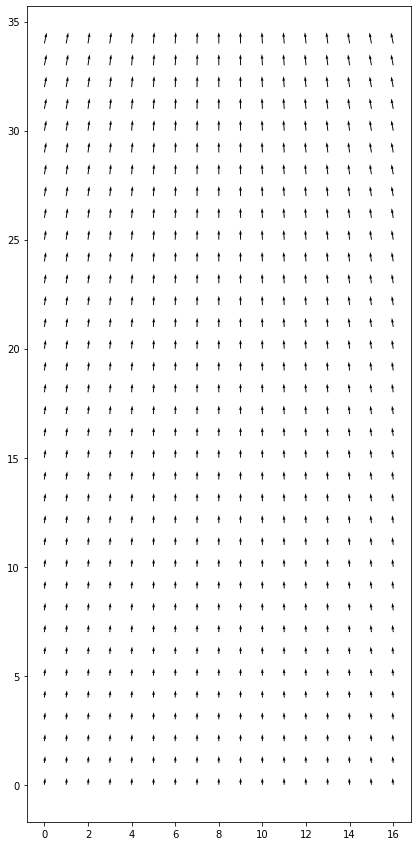

In [162]:
PIXEL_SIZE = 1/8
VIEW_DIST = 3.16

# calculate light direction for each pixel
def light_per_pixel(w, h, lp):
  N = lp.shape[0]
  t = torch.zeros(N, h, w, 2)
  for n in range(0, N):
    for x in range(0, w):
      for y in range(0, h):
        x_t = x-CENTRE_X
        y_t = CENTRE_Y-y
        lx = lp[n][0]
        ly = lp[n][1]
        # t[n][y][x] = torch.tensor((light_pos[n][0]-x_t*PIXEL_SIZE, light_pos[n][1]+y_t*PIXEL_SIZE))
        light_dir = torch.tensor((lx-x_t*PIXEL_SIZE, ly+y_t*PIXEL_SIZE))/(math.sqrt((x_t*PIXEL_SIZE-lx)**2+(y_t*PIXEL_SIZE+ly)**2))
        light_intensity = 1/((math.sqrt((x_t*PIXEL_SIZE-lx)**2+(y_t*PIXEL_SIZE+ly)**2)+VIEW_DIST**2))**2
        t[n][y][x] = light_dir*light_intensity
  return t


per_pixel = light_per_pixel(WIDTH, HEIGHT, light_pos)

p_normals = per_pixel[0].detach().clone().numpy()

U = p_normals[:,:,0]
V = p_normals[:,:,1]

fig, ax = plt.subplots()
q = ax.quiver(U, V, angles='uv')
plt.gca().set_aspect('equal', adjustable='box');

In [145]:
def forward(light_pos):
  # normalize normals and light direction
  n_normals = F.normalize(normals, dim=2)
  # n_lightdir = F.normalize(per_pixel, dim=3)
  # n_lightdir = per_pixel

  light_num = light_pos.shape[0]

  dot_prod = torch.einsum('jkl,ijkl->ijk', n_normals, per_pixel)

  # clamp for normals facing away
  clamped = torch.clamp(dot_prod, 0, 1)
  texture_lighting = i_diff*k_d

  # lighted = torch.einsum('m,ijk->ijk', dot_prod, light_coef)
  out = torch.zeros(light_num, HEIGHT, WIDTH, 3, dtype=torch.float32);
  
  out = texture_lighting * clamped.unsqueeze(3)

  # # find half vector
  # half_v = ((n_normals.detach().clone()+n_lightdir)/2)
  # # print(half_v.shape)

  # x_ind = torch.tensor(0)
  # y_ind = torch.tensor(1)
  # half_x = torch.index_select(half_v, 3, x_ind)
  # half_y = torch.index_select(half_v, 3, y_ind)
  # dot_length = torch.squeeze(torch.sqrt(half_x**2 + half_y**2))
  # spec_dot = torch.ones(N, HEIGHT, WIDTH, dtype=torch.float32) - dot_length
  # spec_dot = torch.clamp(spec_dot, 0, 1)
  # spec_dot = spec_dot**alpha

  # spec_out = k_spec * spec_dot.unsqueeze(3)

  return out#+spec_out

def loss(y, y_pred):
  return ((y_pred - y)**2).mean()

forward(light_pos);

In [164]:
learning_rate = 500000
n_iters=5000
loss_count = []

for epoch in range(0, n_iters):
  y_pred = forward(light_pos)

  l = loss(y, y_pred)

  l.backward()

  with torch.no_grad():
    normals -= learning_rate * normals.grad
    k_d -= learning_rate * k_d.grad

  normals.grad.zero_()
  k_d.grad.zero_()

  if(epoch % 20 == 1):
    loss_count.append(l.item())

  if(epoch % 500 == 0):
    print(f'epoch {epoch+1}: loss = {l:.8f}')


epoch 1: loss = 0.02538176
epoch 501: loss = 0.01271481
epoch 1001: loss = 0.01048320
epoch 1501: loss = 0.01007180
epoch 2001: loss = 0.00999442
epoch 2501: loss = 0.00997959
epoch 3001: loss = 0.00997670
epoch 3501: loss = 0.00997613
epoch 4001: loss = 0.00997602
epoch 4501: loss = 0.00997600


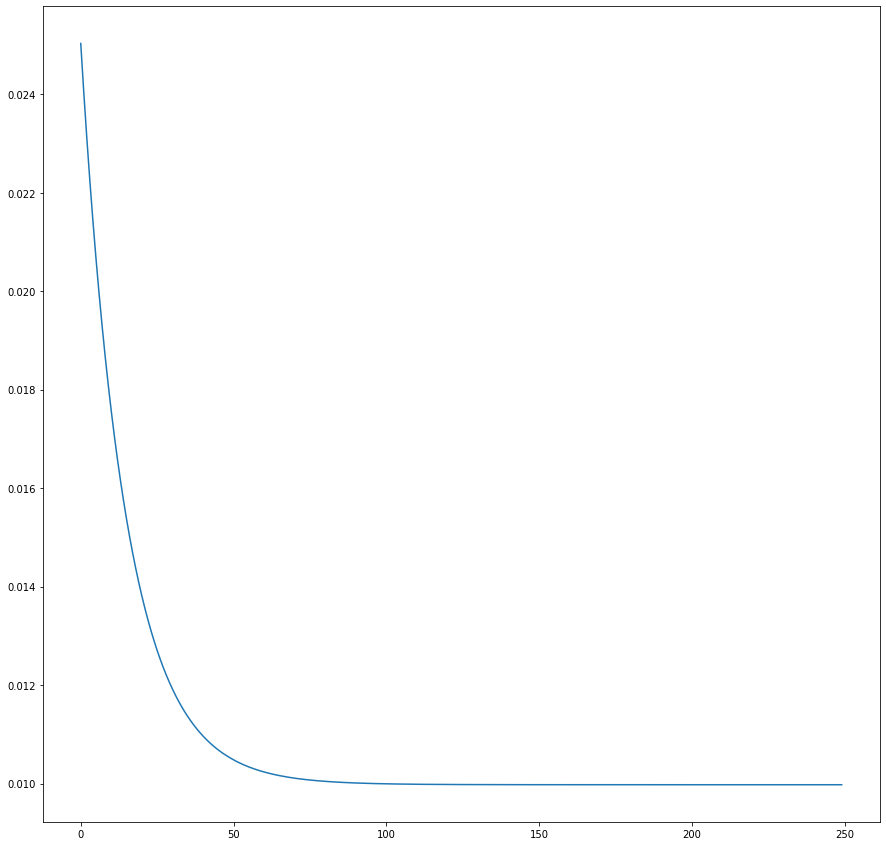

In [165]:
plt.plot(loss_count)

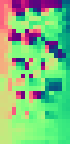

In [166]:
final_normals = normals.detach().clone()

final_normals = to_normal_rgb(final_normals)
final_numpy = final_normals.numpy()
im = Image.fromarray(np.uint8(final_numpy))
im = im.resize((70, 144), resample=0)
im

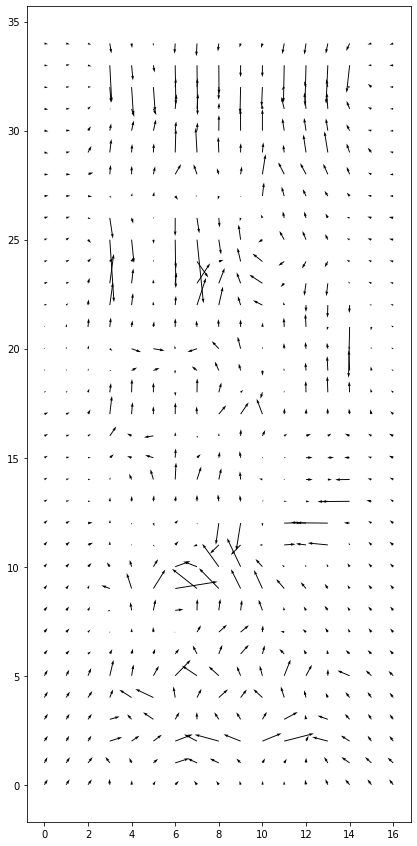

In [167]:
# pyplot quiver the results
vec_normals = normals.detach().clone().numpy()

U = vec_normals[:,:,0]
V = np.flip(vec_normals[:,:,1], 0)

fig, ax = plt.subplots()
q = ax.quiver(U, V, angles='uv')
plt.gca().set_aspect('equal', adjustable='box');
# buf = io.BytesIO()
# plt.savefig(buf, format='png')
# buf.seek(0)
# im = Image.open(buf)
# im = im.resize((140, 288), resample=0)


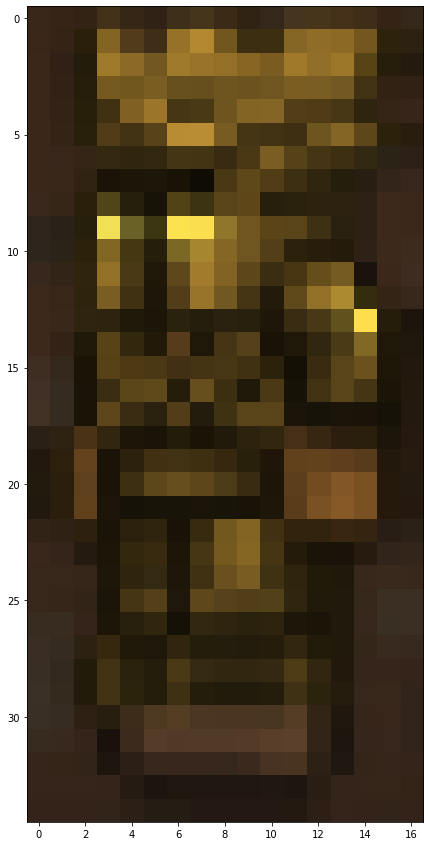

In [168]:
final_tex = k_d.detach().clone()
# light_tex = i_diff.detach().clone().unsqueeze(0)
final_tex = final_tex
final_tex = final_tex / torch.max(final_tex)
np0 = final_tex.numpy()
np0 *= 255
np0 = np.rint(np0)
im = Image.fromarray(np.uint8(np0))
plt.imshow(np.asarray(im))

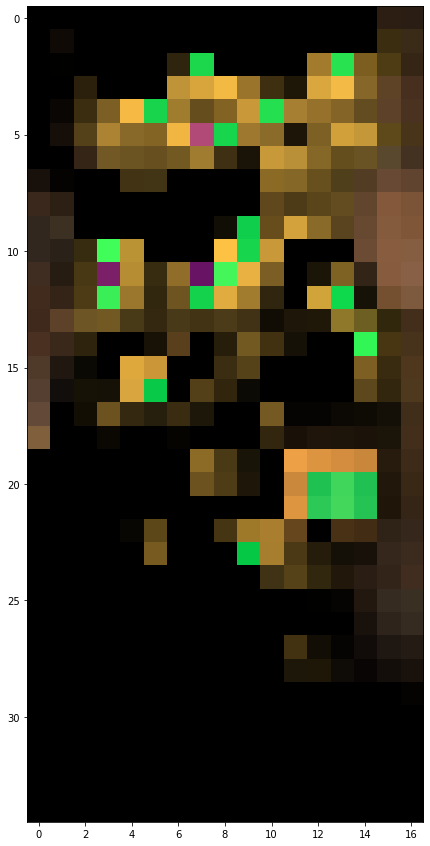

In [169]:
def plotSeg(p1, p2, col):
  x = [p1[0], p2[0]]
  y = [p1[1], p2[1]]
  plt.plot(x, y, c=col)
  plt.gca().set_aspect('equal', adjustable='box');

images = []
rotations = 32
lights = torch.zeros([rotations, 2], dtype=torch.float32)
angle = 2*math.pi/rotations

# create light directions
for num in range(0, rotations):
  newDir = torch.tensor([0., 1.])
  theCos = math.cos(angle*num)
  theSin = math.sin(angle*num)
  rmx = torch.tensor([[theCos, -theSin],[theSin, theCos]])
  newDir = torch.matmul(rmx, newDir)
  lights[num] = newDir

per_pixel = light_per_pixel(WIDTH, HEIGHT, lights)

output = forward(lights)
out_image = output.clone().detach()

np0 = out_image[7].numpy()
np0 *= 255
np0 = np.rint(np0)
im = Image.fromarray(np.uint8(np0))
im = im.resize((17, 35), resample=0)
plt.imshow(np.asarray(im))

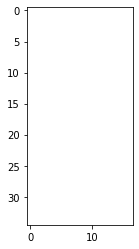

In [ ]:
final_spec = k_spec.detach().clone()
final_spec = final_spec / torch.max(final_spec)
spec0 = final_spec.numpy()
spec0 *= 255
spec0 = np.rint(spec0)
imspec = Image.fromarray(np.uint8(spec0))
plt.imshow(np.asarray(imspec))

Generate cone textures

In [ ]:
N = 8
CONE_WIDTH, CONE_HEIGHT = (21, 21)
CENTRE_X, CENTRE_Y = ((CONE_WIDTH-1)/2, (CONE_HEIGHT-1)/2)
cone_tex = torch.ones(N, CONE_WIDTH, CONE_HEIGHT, 3, dtype=torch.float32)
cone_normals = torch.zeros(CONE_WIDTH, CONE_HEIGHT, 2, dtype=torch.float32)

for x in range(0, CONE_WIDTH):
  for y in range(0, CONE_HEIGHT):
    x_t = x-CENTRE_X
    y_t = CENTRE_Y-y
    if (x_t**2+y_t**2 < (CONE_WIDTH/2)**2):
      cone_normals[y][x] = torch.tensor((x_t, y_t))
    else:
      cone_normals[y][x] = torch.zeros(2, dtype=torch.float32)


In [ ]:
PIXEL_SIZE = 1/10

light_pos = torch.tensor([[0,7],[5,5],[7,0],[5,-5],[0, -7],[-5,-5],[-7,0],[-5,5]], dtype=torch.float32)

# simple implementation: assumes every pixel is at (0, 0)
def light_per_pixel(w, h):
  t = torch.zeros(N, h, w, 2)
  for n in range(0, N):
    for x in range(0, w):
      for y in range(0, h):
        x_t = x-CENTRE_X
        y_t = CENTRE_Y-y
        t[n][y][x] = torch.tensor((light_pos[n][0]-x_t*PIXEL_SIZE, light_pos[n][1]-y_t*PIXEL_SIZE))
  return t


per_pixel = light_per_pixel(CONE_WIDTH, CONE_HEIGHT)

def to_normal_rgb(n, WIDTH, HEIGHT):
    # print(n)
    out = torch.zeros(HEIGHT, WIDTH, 3, requires_grad=False)
    n2 = n.detach().clone()
    out[:,:,2] = 2
    out[:,:,:2] = n2
    for x in range(0, HEIGHT):
      for y in range(0, WIDTH):
        a = out[x][y].clone()
        out[x][y] = a/torch.sqrt((a**2).sum())
    out = out + 1
    out = out * 127
    return out

def forward(light_pos):
  # normalize normals and light direction
  n_normals = F.normalize(cone_normals, dim=2)
  n_lightdir = F.normalize(per_pixel, dim=3)

  # todo: adjust lightdir to factor in distancce from light.
  
  # dot_prod = torch.tensordot(n_normals, n_lightdir, dims=2)
  # dot_prod = torch.matmul(n_normals, n_lightdir)

  dot_prod = torch.einsum('jkl,ijkl->ijk', n_normals, n_lightdir)

  # clamp for normals facing away
  clamped = torch.clamp(dot_prod, 0, 1)

  texture_lighting = cone_tex

  out = texture_lighting * clamped.unsqueeze(3)
  return out

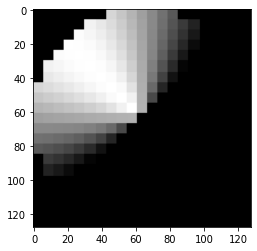

In [ ]:
# cone_normals_2 = to_normal_rgb(cone_normals, CONE_WIDTH, CONE_HEIGHT)
# numpy_array = cone_normals_2.detach().numpy()
# im = Image.fromarray(np.uint8(numpy_array))
# # im = im.resize((128, 128), resample=0)
# plt.imshow(np.asarray(im))

out_image = forward(light_pos).detach().clone();

# for n in range(0, N):
np0 = out_image[7].numpy()
np0 *= 255
np0 = np.rint(np0)
im = Image.fromarray(np.uint8(np0))
im.save("cone7.jpg")
im = im.resize((128, 128), resample=0)
plt.imshow(np.asarray(im))